# Imports

In [1]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import os
import torch
import torchvision
from PIL.Image import Image

from model.dataloader import ImageDataLoader, ImageSketchDataLoader
from taming.models.vqgan import GumbelVQ
from omegaconf import OmegaConf
import yaml
import torchvision.transforms.functional as TF
import torchvision.transforms as T

## Load VQ-GAN

In [3]:
!curl --help

Usage: curl [options...] <url>
 -d, --data <data>   HTTP POST data
 -f, --fail          Fail silently (no output at all) on HTTP errors
 -h, --help <category>  Get help for commands
 -i, --include       Include protocol response headers in the output
 -o, --output <file>  Write to file instead of stdout
 -O, --remote-name   Write output to a file named as the remote file
 -s, --silent        Silent mode
 -T, --upload-file <file>  Transfer local FILE to destination
 -u, --user <user:password>  Server user and password
 -A, --user-agent <name>  Send User-Agent <name> to server
 -v, --verbose       Make the operation more talkative
 -V, --version       Show version number and quit

This is not the full help, this menu is stripped into categories.
Use "--help category" to get an overview of all categories.
For all options use the manual or "--help all".


## Load transformer

In [11]:
# download the f16 model
os.makedirs('./logs/vqgan_imagenet_f16_1024/checkpoints', exist_ok=True)
os.makedirs('./logs/vqgan_imagenet_f16_1024/configs', exist_ok=True)

url1 = 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1'
url2 = 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1'
response = requests.get(url1, stream=True)
with open('./logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

response = requests.get(url2, stream=True)
with open('./logs/vqgan_imagenet_f16_1024/configs/model.yaml', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

In [4]:
# download the weights of the VQ-GAN
# os.makedirs('./logs/vqgan_gumbel_f8/checkpoints', exist_ok=True)
# os.makedirs('./logs/vqgan_gumbel_f8/configs', exist_ok=True)
#
# url1 = 'https://heibox.uni-heidelberg.de/f/34a747d5765840b5a99d/?dl=1'
# url2 = 'https://heibox.uni-heidelberg.de/f/b24d14998a8d4f19a34f/?dl=1'
# response = requests.get(url1, stream=True)
# with open('./logs/vqgan_gumbel_f8/checkpoints/last.ckpt', 'wb') as out_file:
#     shutil.copyfileobj(response.raw, out_file)
# del response
#
# response = requests.get(url2, stream=True)
# with open('./logs/vqgan_gumbel_f8/configs/model.yaml', 'wb') as out_file:
#     shutil.copyfileobj(response.raw, out_file)
# del response

In [2]:
# load the checkpoint
pl_sd = torch.load('./logs/vqgan_gumbel_f8/checkpoints/last.ckpt', map_location="cpu")
sd = pl_sd["state_dict"]

In [3]:
def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec, z


config1024 = load_config("./logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
config1024

{'model': {'base_learning_rate': 4.5e-06, 'target': 'taming.models.vqgan.GumbelVQ', 'params': {'kl_weight': 1e-08, 'embed_dim': 256, 'n_embed': 8192, 'monitor': 'val/rec_loss', 'temperature_scheduler_config': {'target': 'taming.lr_scheduler.LambdaWarmUpCosineScheduler', 'params': {'warm_up_steps': 0, 'max_decay_steps': 1000001, 'lr_start': 0.9, 'lr_max': 0.9, 'lr_min': 1e-06}}, 'ddconfig': {'double_z': False, 'z_channels': 256, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 1, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [32], 'dropout': 0.0}, 'lossconfig': {'target': 'taming.modules.losses.vqperceptual.DummyLoss'}}}}

In [4]:
def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def preprocess(img, target_image_size=256):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

In [5]:
model = GumbelVQ(**config1024.model.params)
missing, unexpected = model.load_state_dict(sd, strict=False)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


In [6]:
# dataset = ImageDataLoader(path_images='C:/Users/felix/PycharmProjects/HLCV-Project/dataset/images')
dataset = ImageSketchDataLoader(path_images='C:/Users/felix/PycharmProjects/HLCV-Project/dataset/images', path_sketches='C:/Users/felix/PycharmProjects/HLCV-Project/dataset/sketches')

In [7]:
img = preprocess_vqgan(dataset[1]['image']) # normalize to [-1, 1]
img = img.permute(2, 0, 1)
img.shape

torch.Size([3, 240, 360])

In [10]:
image_idx = 0
img = preprocess(PIL.Image.open(dataset[image_idx]['image_path']).convert('RGB'), target_image_size=320-32*3)
sketch = preprocess(PIL.Image.open(dataset[image_idx]['sketch_path']).convert('RGB'), target_image_size=320-32*3)
img = img.to('cuda')
sketch = sketch.to('cuda')
model = model.to('cuda')

img = img.squeeze()

print(img.shape, sketch.shape)

model.encode(img)

C:\Users\felix\AppData\Local\Temp\ipykernel_8876\4125247881.py:13: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
C:\Users\felix\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([3, 224, 224]) torch.Size([1, 3, 224, 224])


RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [128] and input of shape [128, 224, 224]

In [20]:
r_img, z_img = reconstruct_with_vqgan(img, model)
r_sketch, z_sketch = reconstruct_with_vqgan(sketch, model)

VQGAN --- GumbelVQ: latent shape: torch.Size([28, 28])
VQGAN --- GumbelVQ: latent shape: torch.Size([28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


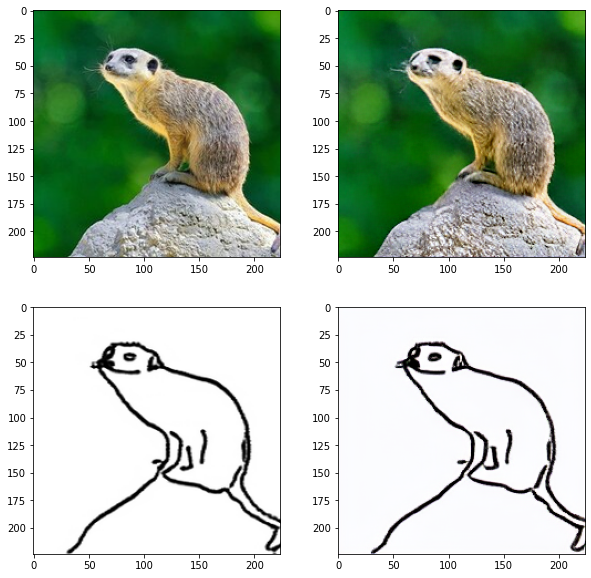

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img[0].cpu().detach().permute(1, 2, 0))
ax[0, 1].imshow(r_img[0].cpu().detach().permute(1, 2, 0))

# plt.xlabel('original')

ax[1, 0].imshow(sketch[0].cpu().detach().permute(1, 2, 0))
ax[1, 1].imshow(r_sketch[0].cpu().detach().permute(1, 2, 0))

plt.savefig('out.png', dpi=300, facecolor='white')